# Evaluating the Model

### Install Requirements

In [2]:
%%capture

!pip install fiftyone
!pip install pyzbar
!pip install opencv-python
!pip install seaborn

### Import Required Libraries

In [12]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.data.catalog import Metadata
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode

import os
import sys
import numpy as np
import pandas as pd
import fiftyone as fo
from PIL import Image, ImageOps
from PIL.ExifTags import TAGS
from pathlib import Path
from pyzbar.pyzbar import decode
from pyzbar.pyzbar import ZBarSymbol
from torchvision import transforms

### Specify Model

There are several output folders from training multiple models.  

In [11]:
today = "12-6"
output_folder = "kfold_output_" + today
k = 4

In [5]:
dataset = fo.Dataset.from_dir(
    data_path="/home/jovyan/work/data/",
    labels_path=f"/home/jovyan/work/{output_folder}/test_{k}.json",
    dataset_type=fo.types.COCODetectionDataset, 
    name=f"test_{today}_{k}",
    label_types="segmentations"
)


 100% |███████████████████| 35/35 [7.9s elapsed, 0s remaining, 5.0 samples/s]       


In [6]:
print(dataset)

Name:        test_12-6_4
Media type:  image
Num samples: 35
Persistent:  False
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [8]:
base_path = f"/home/jovyan/work/{output_folder}/fold_{k}/"

leaf_cfg = get_cfg()
leaf_cfg.MODEL.DEVICE='cpu'
leaf_cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
leaf_cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
leaf_cfg.MODEL.WEIGHTS = base_path + "model_final.pth" # path to trained weights
leaf_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set a custom testing threshold

leaf_predictor = DefaultPredictor(leaf_cfg)

# set up metadata
leaf_metadata = Metadata()
leaf_metadata.set(thing_classes = ['leaf', 'qr', 'red-square'])

[05/08 23:10:27 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

namespace(thing_classes=['leaf', 'qr', 'red-square'])

In [9]:
from IPython.display import display


In [10]:


with fo.ProgressBar() as pb:
    for sample in pb(dataset):

        # run interence on selected image
        image = Image.open(sample.filepath)
        image = ImageOps.exif_transpose(image)
        
        image_arr = np.array(image)
        h, w, c = image_arr.shape
        print (h,w,c)
        outputs = leaf_predictor(image_arr)
        
        # get bboxes and class labels
        pred_boxes = outputs["instances"].pred_boxes.tensor.numpy()
        pred_masks = outputs["instances"].pred_masks.numpy()
        class_labels = outputs["instances"].pred_classes.numpy()
        scores = outputs["instances"].scores.numpy()
        
        # track indicies of 
        qr_indices = []
        leaf_indices = []
        red_square_indices = []
        
        # get indices of leaves and qr codes
        for i, label in enumerate(class_labels):
            if label == 0: # leaf
                leaf_indices.append(i)
            elif label == 1: # qr
                qr_indices.append(i)
            elif label == 2: # red-square
                red_square_indices.append(i)
                
        classes = ['leaf', 'qr', 'red-square']
        
        detections = []
        
        # track pixel 
        red_square_pixels = 0
        leaf_pixels = 0
        qr_pixels = 0
        
        for label, mask, box, score in zip(class_labels, pred_masks, pred_boxes, scores):
           
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            x1, y1, x2, y2 = box
            rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]
            
            bbox_mask = mask[round(y1):round(y2), round(x1):round(x2)]
            mask_h, mask_w = bbox_mask.shape
            
            mask_pixel_count = np.count_nonzero(mask)
            class_label = classes[label]
            
            # print('label: ', class_label)
            # print('mask_pixel_count: ', mask_pixel_count)
            
            if class_label == 'leaf':
                leaf_pixels += mask_pixel_count
            elif class_label == 'red-square':
                red_square_pixels = mask_pixel_count
            elif class_label == 'qr':
                qr_pixels = mask_pixel_count

            
            
            # print(mask.shape)
            # print(np.count_nonzero(mask))
            
            # print(rel_box)
            
            detections.append(
                fo.Detection(
                    label=classes[label],
                    bounding_box=rel_box,
                    mask=bbox_mask,
                    confidence=score,
                    original_bbox=box
                )
            )
        
        
        print('image: ', sample.filepath)
        print('red_square_pixels: ', red_square_pixels)
        print('leaf_pixels: ', leaf_pixels)
        print('qr_pixels: ', qr_pixels)
        
        leaf_area = None
        
        if red_square_pixels:
            leaf_area = (4 * leaf_pixels) / red_square_pixels
            print ('leaf area: ' + str(leaf_area) + ' cm2')
        elif qr_pixels:
            leaf_area = (1.44 * leaf_pixels) / qr_pixels
            print ('leaf area: ' + str(leaf_area) + ' cm2')
        
        sample["predictions"] = fo.Detections(detections=detections)
        sample["height"] = h
        sample["width"] = w
        sample["area"] = leaf_area
        
        sample.save()


        

   0% ||------------------|  0/35 [15.8ms elapsed, ? remaining, ? samples/s] 

/opt/conda/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


4640 6960 3                                                                  
image:  /home/jovyan/work/data/leaves/new_batch/IMG_6157.JPG
red_square_pixels:  1165049
leaf_pixels:  67508
qr_pixels:  319214
leaf area: 0.23177737588719444 cm2
4640 6960 3                                                                     
image:  /home/jovyan/work/data/leaves/new_batch/IMG_6147.JPG
red_square_pixels:  662305
leaf_pixels:  2822748
qr_pixels:  575097
leaf area: 17.048024701610284 cm2
4640 6960 3                                                                     
image:  /home/jovyan/work/data/leaves/new_batch/IMG_6056.JPG
red_square_pixels:  661001
leaf_pixels:  2532405
qr_pixels:  186538
leaf area: 15.324666679778094 cm2
4640 6960 3                                                                      
image:  /home/jovyan/work/data/leaves/new_batch/IMG_6036.JPG
red_square_pixels:  1192759
leaf_pixels:  2418519
qr_pixels:  310776
leaf area: 8.110671141446009 cm2
4640 6960 3               

In [ ]:
print(dataset.last())
!pip install openpyxl

In [32]:
import pandas as pd

df = pd.read_excel('/home/jovyan/work/First_batch_area.xlsx')
df['ml_area'] = None
df['ml_area'] = df['ml_area'].astype(float)
print(df)


          picture  area_cm2  ml_area
0    IMG_5792.tif      0.16      NaN
1    IMG_5793.tif      0.07      NaN
2    IMG_5794.tif      0.37      NaN
3    IMG_5795.tif      0.09      NaN
4    IMG_5849.tif      0.66      NaN
..            ...       ...      ...
174  IMG_6055.tif      4.70      NaN
175  IMG_6056.tif     16.53      NaN
176  IMG_6057.tif      0.83      NaN
177  IMG_6058.tif      0.55      NaN
178  IMG_6059.tif      4.95      NaN

[179 rows x 3 columns]


In [1]:
missing = []

for sample in dataset:

    filename = sample.filepath.split('/')[-1].split('.')[0]
    print(filename)
    print(sample.area)
    
    if not df.loc[df['picture'].str.startswith(filename)].empty:
        df.loc[df['picture'].str.startswith(filename), 'ml_area'] = float(round(sample.area, 2)) 
    else:
        missing.append(filename)

print(df)
print(missing)


    

NameError: name 'dataset' is not defined

In [34]:
df_area = df[df['ml_area'] >= 0.0]
print(df_area)
df.dtypes

          picture  area_cm2  ml_area
22   IMG_5869.tif      0.09     0.15
27   IMG_5874.tif      0.29     0.21
30   IMG_5877.tif      0.43     0.40
53   IMG_5926.tif      0.14     0.11
62   IMG_5935.tif      0.20     0.22
63   IMG_5936.tif      0.12     0.14
71   IMG_5944.tif      0.13     0.12
79   IMG_5952.tif      0.13     0.11
83   IMG_5956.tif     10.17     9.29
87   IMG_5960.tif      0.73     0.68
93   IMG_5967.tif      3.13     2.67
96   IMG_5970.tif      2.70     2.55
100  IMG_5974.tif      1.35     1.27
113  IMG_5989.tif      1.79     1.65
114  IMG_5990.tif      1.97     1.86
115  IMG_5991.tif      2.37     2.26
123  IMG_5999.tif      3.64     3.42
132  IMG_6008.tif      0.08     0.07
138  IMG_6016.tif      0.66     0.49
140  IMG_6018.tif      7.97     6.87
141  IMG_6019.tif      3.77     3.24
145  IMG_6023.tif      2.22     2.41
153  IMG_6031.tif      0.81     0.74
156  IMG_6034.tif      0.90     0.80
158  IMG_6036.tif      8.31     8.06
160  IMG_6038.tif      6.05     5.28
1

picture      object
area_cm2    float64
ml_area     float64
dtype: object

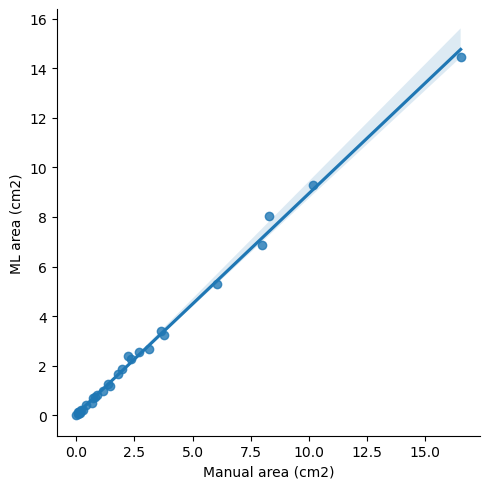

In [35]:
import seaborn as sns
plt = sns.lmplot(data=df_area, x='area_cm2', y='ml_area', fit_reg=True)
plt.set(xlabel='Manual area (cm2)', ylabel='ML area (cm2)')

In [36]:
df_area.corr()

,area_cm2,ml_area
area_cm2,1.000000,0.998592
ml_area,0.998592,1.000000


In [38]:
from scipy import stats

corr = stats.pearsonr(df_area.area_cm2, df_area.ml_area)
print(corr)
r_squared = corr.statistic * corr.statistic
print('r^2:', r_squared)

PearsonRResult(statistic=0.998591793228608, pvalue=2.92767450322614e-37)
r^2: 0.9971855695035271


In [39]:
df_area.corr(method='pearson')

,area_cm2,ml_area
area_cm2,1.000000,0.998592
ml_area,0.998592,1.000000


In [40]:
df_area.corr(method='kendall')

,area_cm2,ml_area
area_cm2,1.000000,0.942396
ml_area,0.942396,1.000000


In [41]:
count = 0

for i in range(0, 1000):
    df_area_permutation = df_area.copy()
    
    # permute ml_area column
    # df_area_permutation['area_cm2'] = np.random.permutation(df_area_permutation['area_cm2'])
    df_area_permutation['ml_area'] = np.random.permutation(df_area_permutation['ml_area'])
    # print(df_area_permutation)
    
    # get r^2 value for permutation
    permutation_corr = stats.pearsonr(df_area_permutation.area_cm2, df_area_permutation.ml_area)
    permutation_r_squared = permutation_corr.statistic * permutation_corr.statistic
    # print(permutation_corr)
    # print(permutation_r_squared)
    
    if permutation_r_squared > r_squared:
        count += 1

print(count)
    
    
    
    
    
    

0


In [42]:
session = fo.launch_app(dataset, port=5151, address="0.0.0.0")

In [ ]:
session.refresh()

In [43]:
import matplotlib.pyplot as plt
# [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

def convert_to_pixels(fo_format, h, w):
    x1, y1, x2, y2 = fo_format
    return [x1 * w, y1 * h, (w * x2) + (x1 * w), (h * y2) + (y1 * h)]


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6157.JPG
Prediction pixel count:  63005
Ground truth pixel count:  59201
IOU: 0.8717127934937434
Dice: 0.9314599937809928


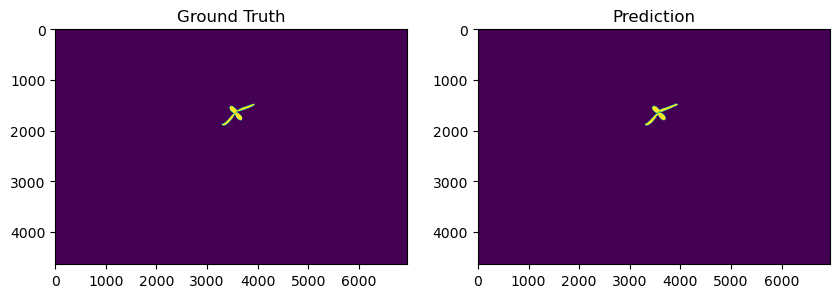


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6147.JPG
Prediction pixel count:  2615502
Ground truth pixel count:  2415298
IOU: 0.8545299182477737
Dice: 0.9215595929076886


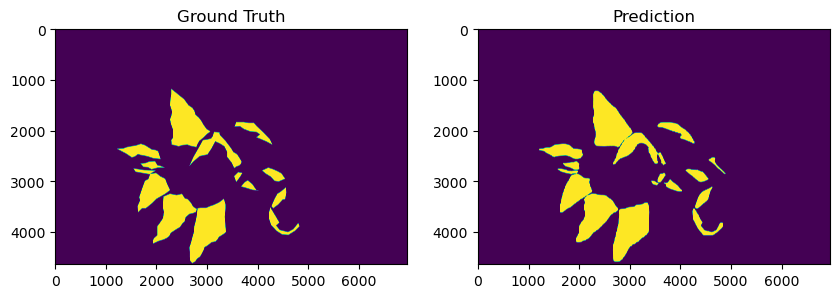


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6056.JPG
Prediction pixel count:  2306971
Ground truth pixel count:  2162560
IOU: 0.848442038230785
Dice: 0.9180077283276478


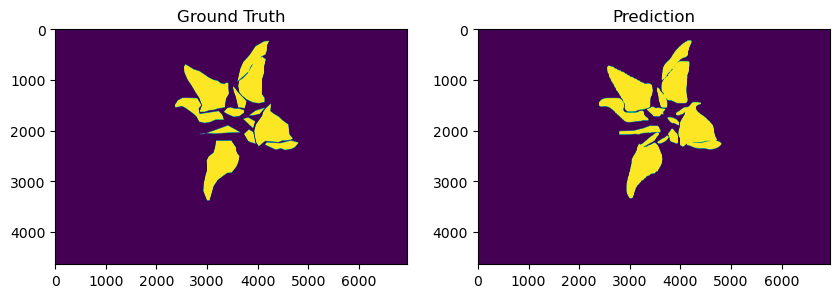


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6036.JPG
Prediction pixel count:  2267484
Ground truth pixel count:  2333647
IOU: 0.9016214777505049
Dice: 0.9482659806903998


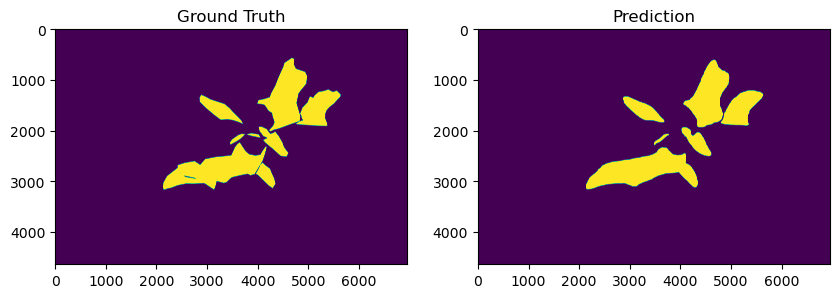


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6148.JPG
Prediction pixel count:  610266
Ground truth pixel count:  606815
IOU: 0.9211830669322785
Dice: 0.9589747929677647


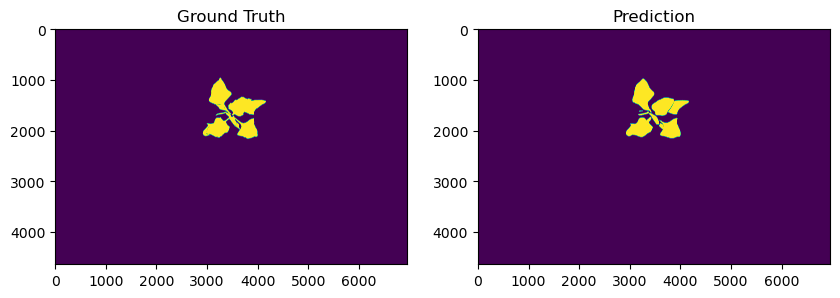


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5877.JPG
Prediction pixel count:  110456
Ground truth pixel count:  113345
IOU: 0.8644334663478761
Dice: 0.9272880818226907


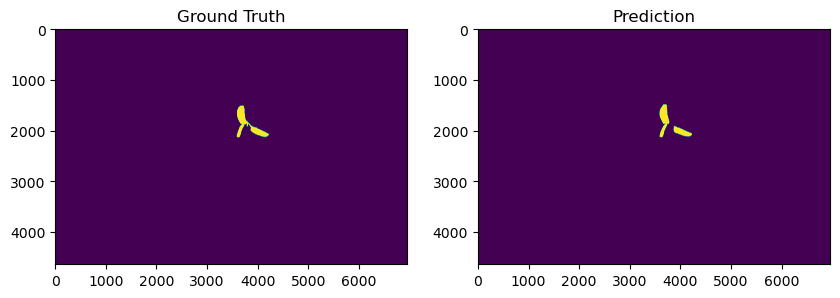


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6150.JPG
Prediction pixel count:  2181159
Ground truth pixel count:  2192282
IOU: 0.902893472641431
Dice: 0.9489690154731709


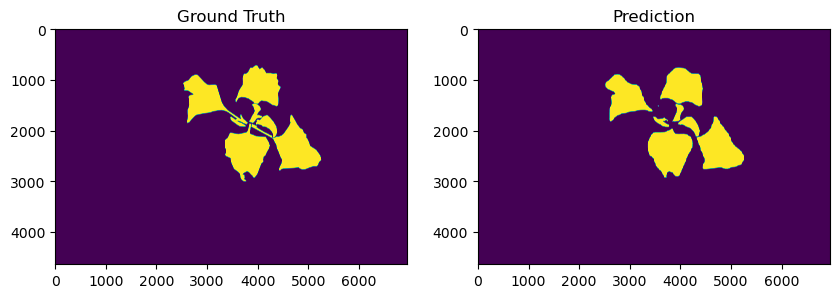


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6160.JPG
Prediction pixel count:  8702
Ground truth pixel count:  24250
IOU: 0.3415845615177917
Dice: 0.5092255401796553


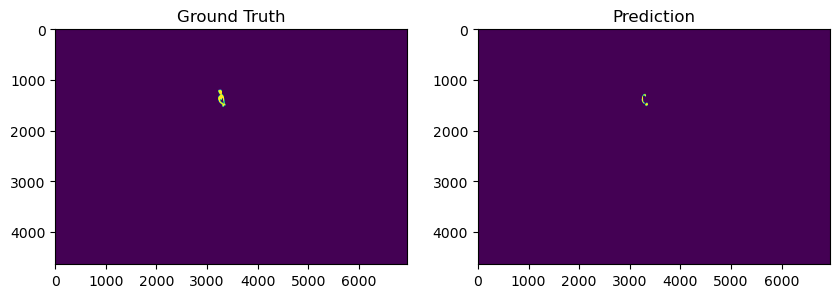


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5956.JPG
Prediction pixel count:  2565466
Ground truth pixel count:  2586676
IOU: 0.9316546047809383
Dice: 0.9646182112216628


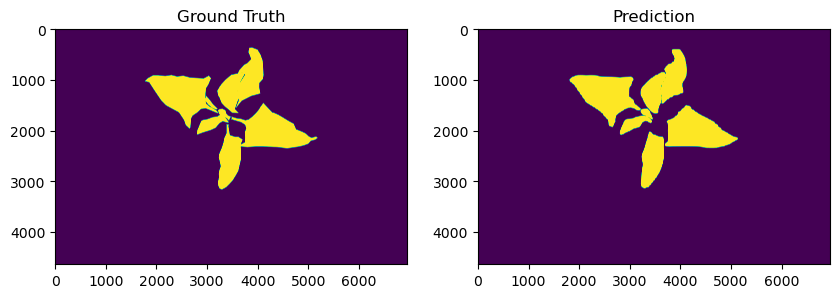


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5952.JPG
Prediction pixel count:  29820
Ground truth pixel count:  34584
IOU: 0.7481135660387601
Dice: 0.8559095708341097


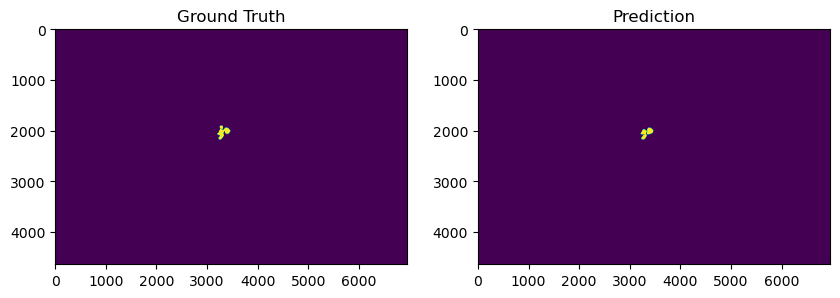


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5874.JPG
Prediction pixel count:  60132
Ground truth pixel count:  69813
IOU: 0.7473241179001722
Dice: 0.8553926661279773


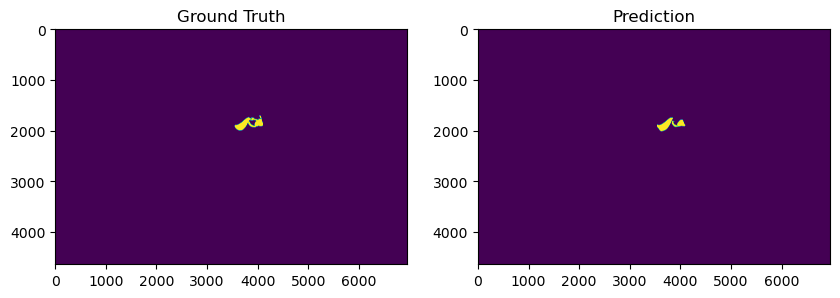


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/IMG_5869.JPG
Prediction pixel count:  27153
Ground truth pixel count:  25281
IOU: 0.8348964165733482
Dice: 0.9100202158904528


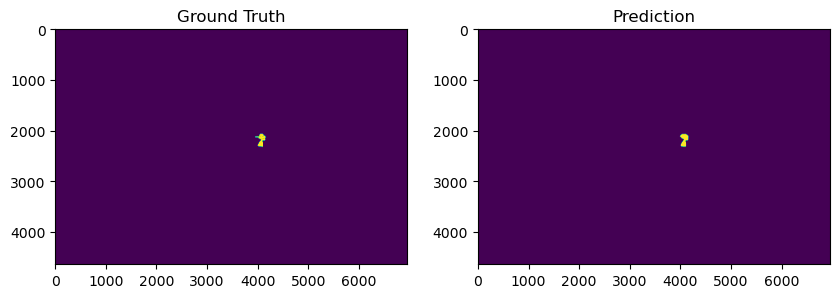


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6052.JPG
Prediction pixel count:  165827
Ground truth pixel count:  172114
IOU: 0.9059653595176728
Dice: 0.9506629855507323


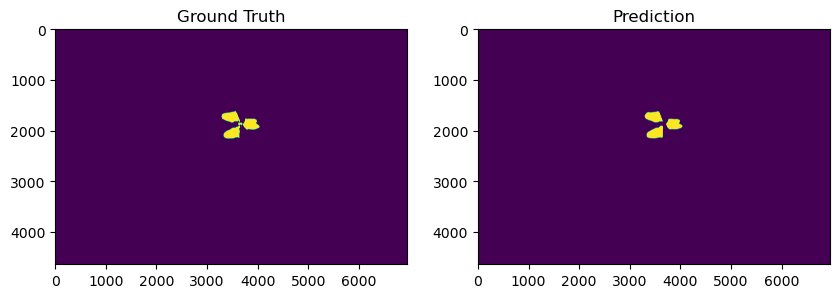


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6040.JPG
Prediction pixel count:  354169
Ground truth pixel count:  378902
IOU: 0.8611673187314821
Dice: 0.9254055882718045


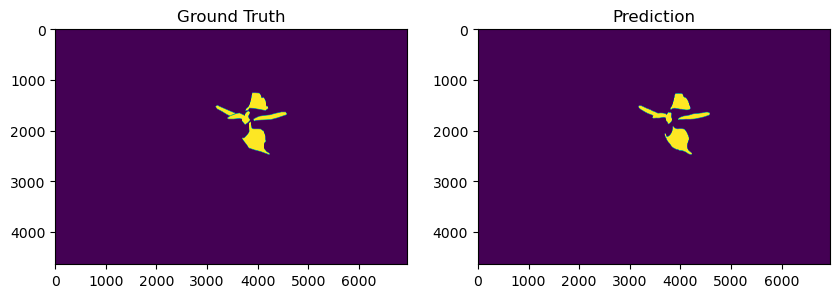


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6039.JPG
Prediction pixel count:  0
Ground truth pixel count:  0
IOU: None
Dice: None


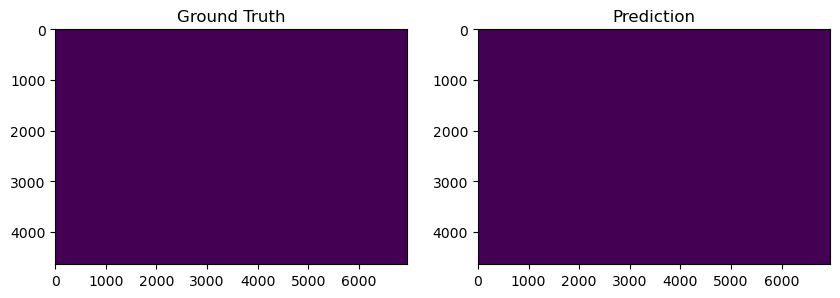


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6038.JPG
Prediction pixel count:  1579707
Ground truth pixel count:  1658406
IOU: 0.8863856411331901
Dice: 0.9397714039009757


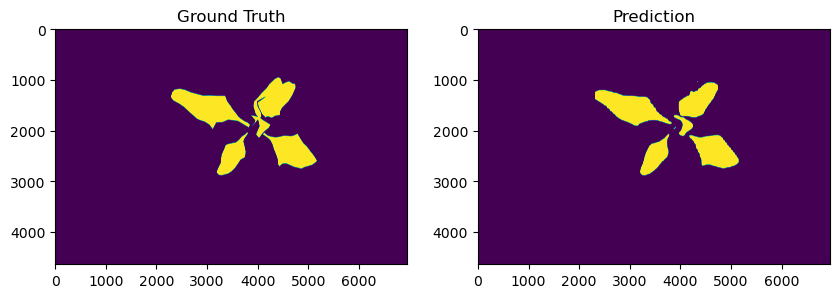


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6034.JPG
Prediction pixel count:  236542
Ground truth pixel count:  249294
IOU: 0.9019201785120085
Dice: 0.9484311578392709


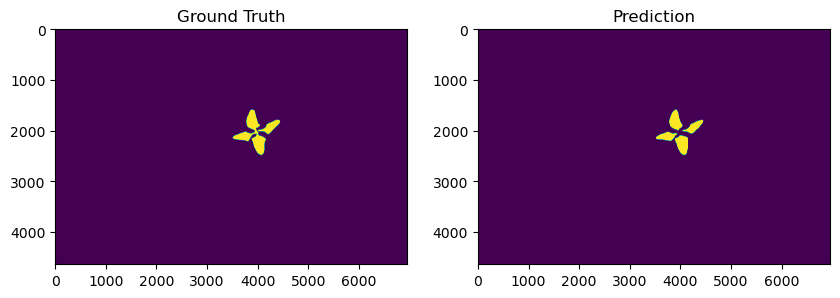


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6031.JPG
Prediction pixel count:  217995
Ground truth pixel count:  230139
IOU: 0.8975542419674464
Dice: 0.9460116840052306


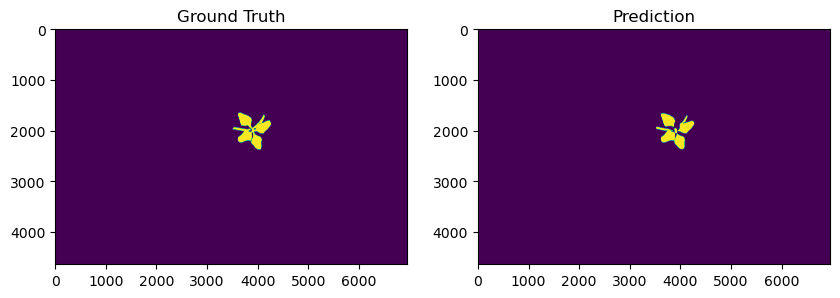


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6023.JPG
Prediction pixel count:  310708
Ground truth pixel count:  333171
IOU: 0.8542125027357654
Dice: 0.9213749788391918


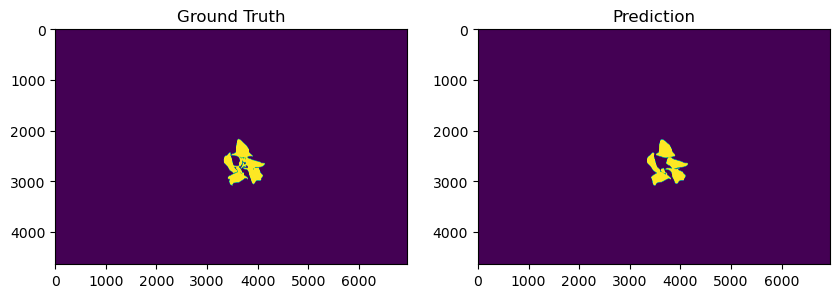


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6018.JPG
Prediction pixel count:  1108193
Ground truth pixel count:  1185763
IOU: 0.8558823862542333
Dice: 0.9223455027036264


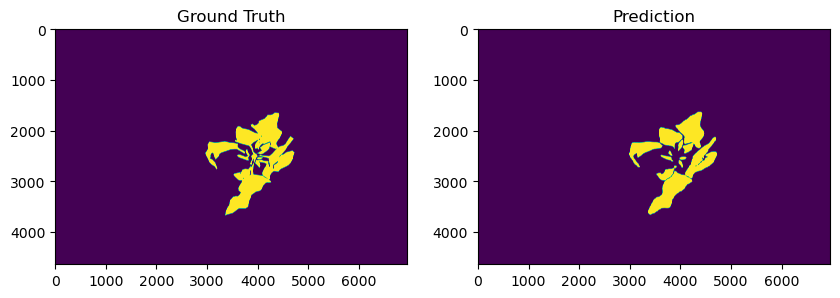


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5970.JPG
Prediction pixel count:  701572
Ground truth pixel count:  698462
IOU: 0.9050025512807429
Dice: 0.9501326396358946


/tmp/ipykernel_137845/5610809.py:91: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1, 2)


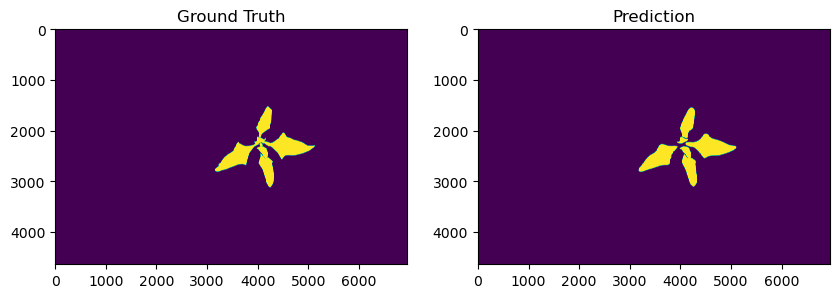


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5960.JPG
Prediction pixel count:  189489
Ground truth pixel count:  201550
IOU: 0.8489103864357415
Dice: 0.9182818082083885


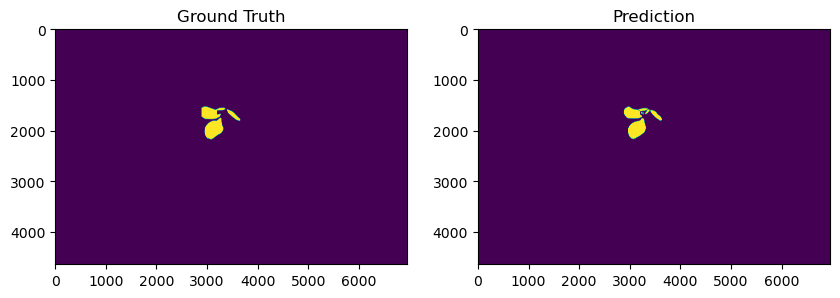


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5926.JPG
Prediction pixel count:  29353
Ground truth pixel count:  35793
IOU: 0.6118066208125092
Dice: 0.7591563564915728


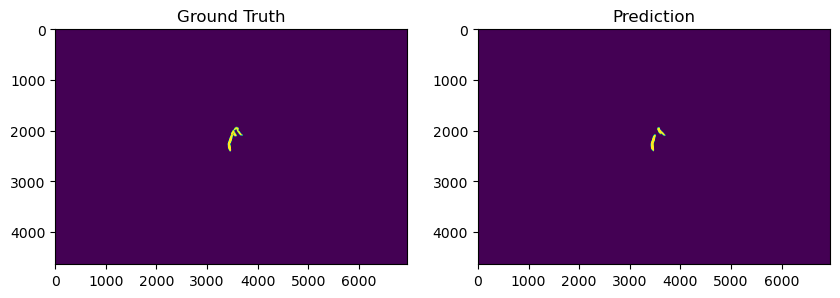


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6019.JPG
Prediction pixel count:  535764
Ground truth pixel count:  561906
IOU: 0.894268718430149
Dice: 0.9441835888746163


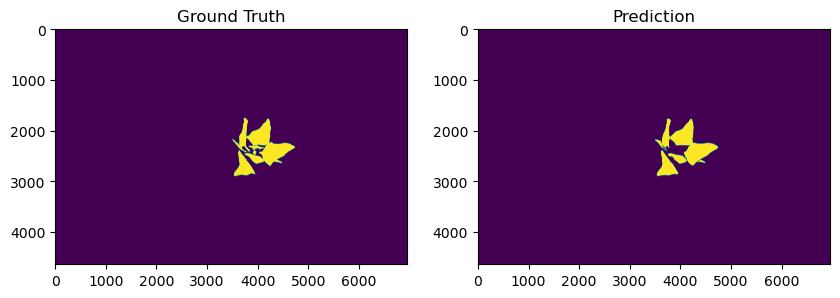


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6016.JPG
Prediction pixel count:  81162
Ground truth pixel count:  89651
IOU: 0.8336034865871593
Dice: 0.9092516377559086


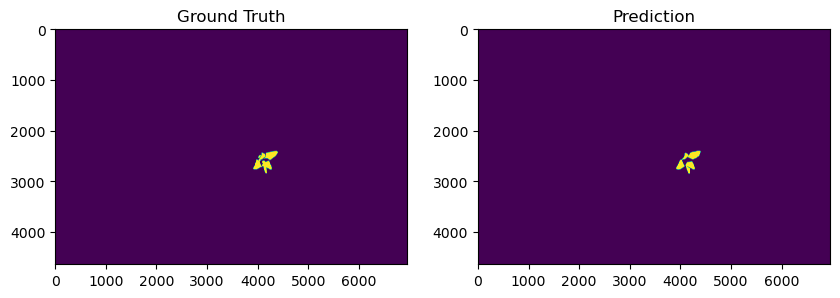


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_6008.JPG
Prediction pixel count:  19564
Ground truth pixel count:  19749
IOU: 0.8940547311620736
Dice: 0.9440643044285605


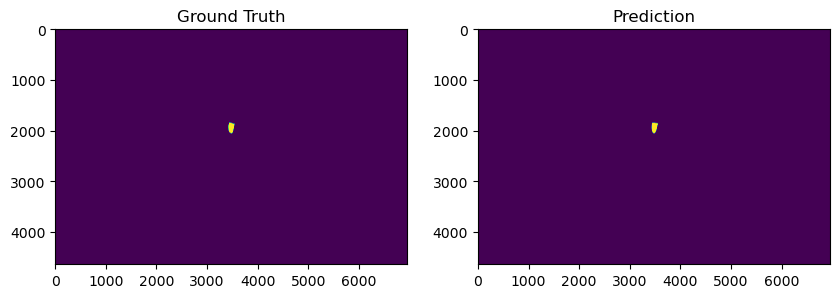


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5999.JPG
Prediction pixel count:  920699
Ground truth pixel count:  913927
IOU: 0.8713646304244936
Dice: 0.9312611943796719


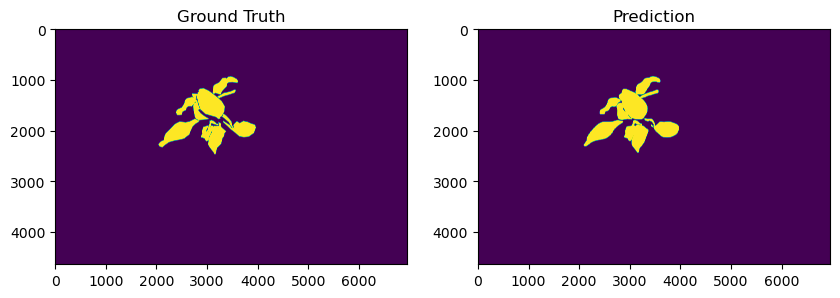


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5991.JPG
Prediction pixel count:  637597
Ground truth pixel count:  644526
IOU: 0.923373952334305
Dice: 0.9601606086155541


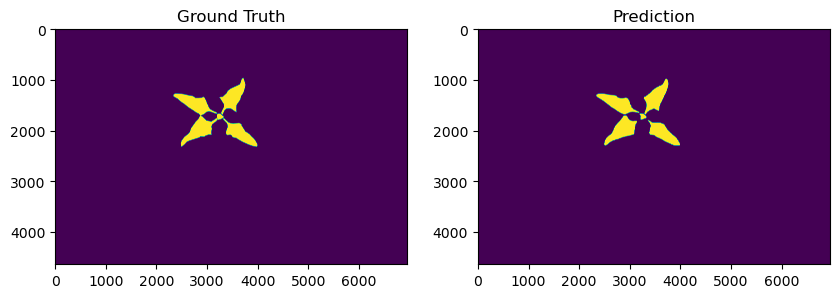


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5990.JPG
Prediction pixel count:  525792
Ground truth pixel count:  534589
IOU: 0.9146914211114582
Dice: 0.9554452597698374


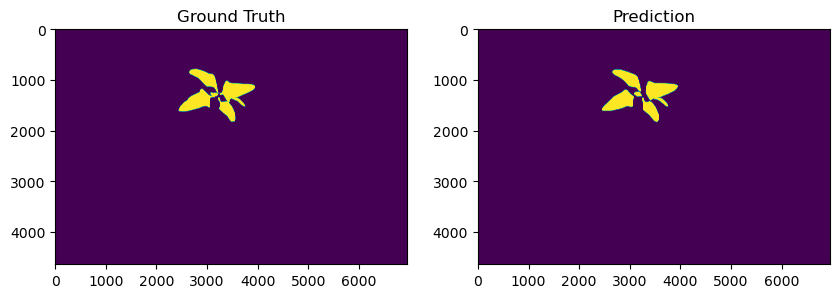


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5989.JPG
Prediction pixel count:  464738
Ground truth pixel count:  481491
IOU: 0.9240548283918509
Dice: 0.9605285824044708


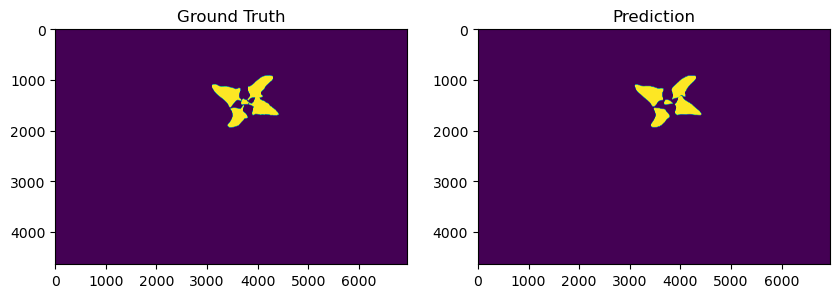


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5944.JPG
Prediction pixel count:  32441
Ground truth pixel count:  31759
IOU: 0.8429740203817999
Dice: 0.914797507788162


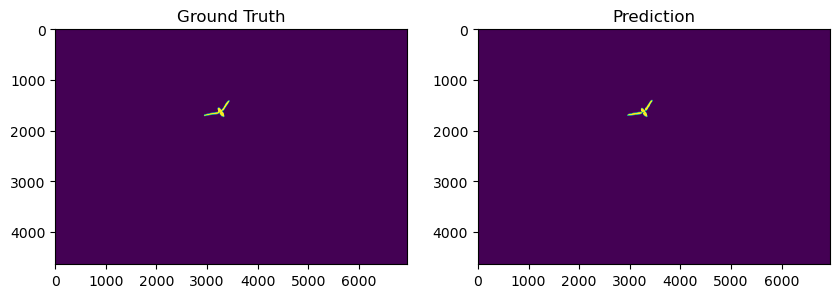


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5935.JPG
Prediction pixel count:  47949
Ground truth pixel count:  51567
IOU: 0.8468219356036003
Dice: 0.9170585634470839


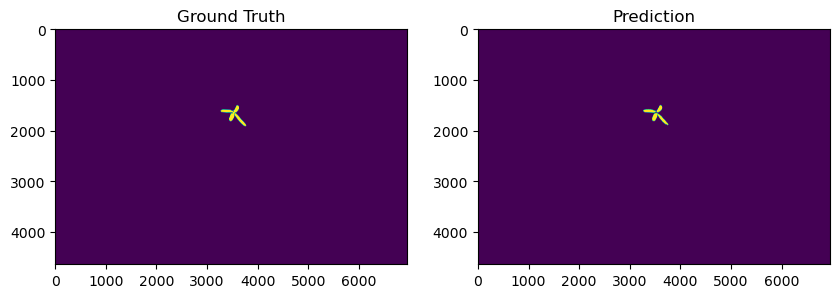


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5936.JPG
Prediction pixel count:  27823
Ground truth pixel count:  28904
IOU: 0.8144511258955988
Dice: 0.8977382904084474


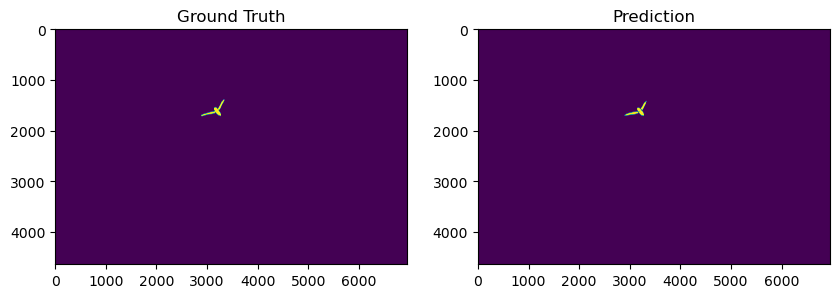


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5974.JPG
Prediction pixel count:  356032
Ground truth pixel count:  361303
IOU: 0.9056366688981691
Dice: 0.950481992374553


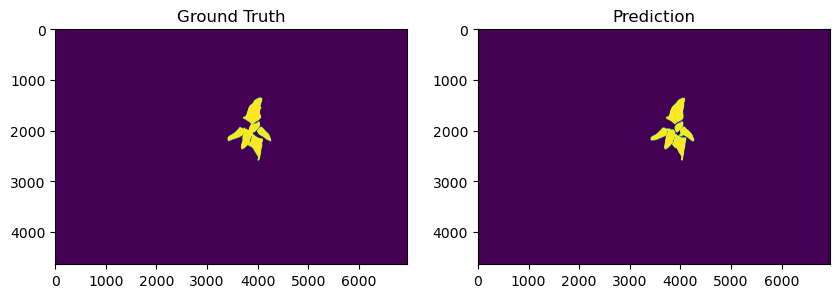


 --------------------------------------------------------------

Sample:  /home/jovyan/work/data/leaves/new_batch/IMG_5967.JPG
Prediction pixel count:  740310
Ground truth pixel count:  812424
IOU: 0.8721939409139029
Dice: 0.9317346048969108


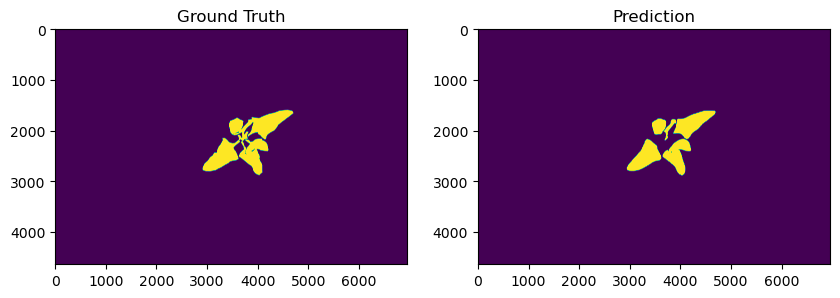

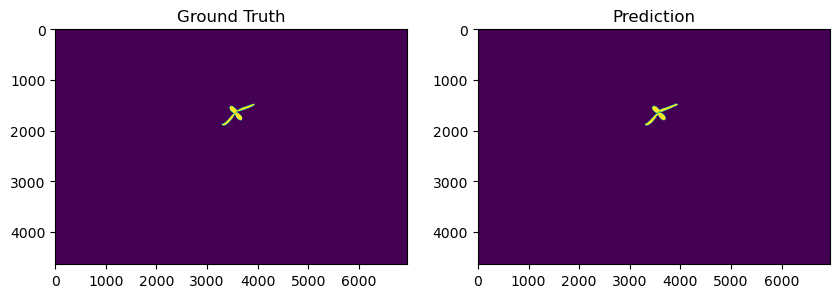

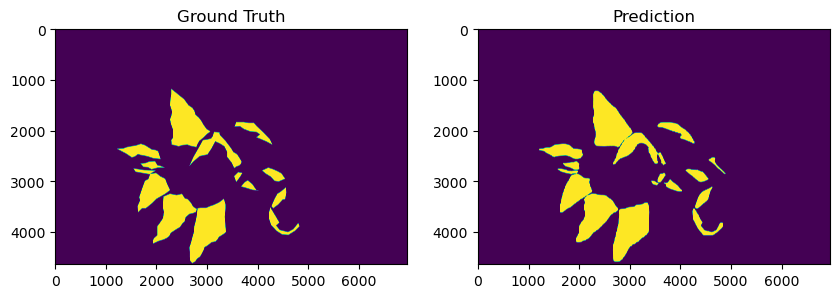

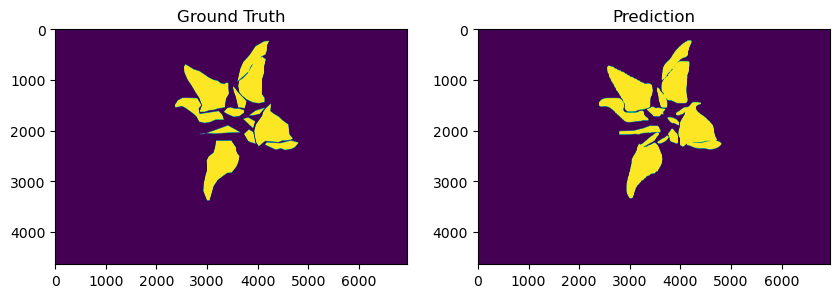

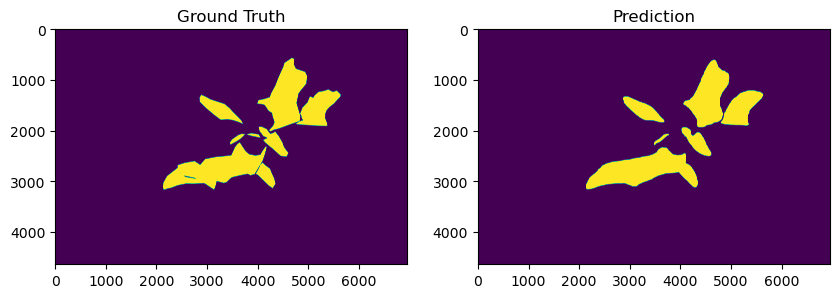

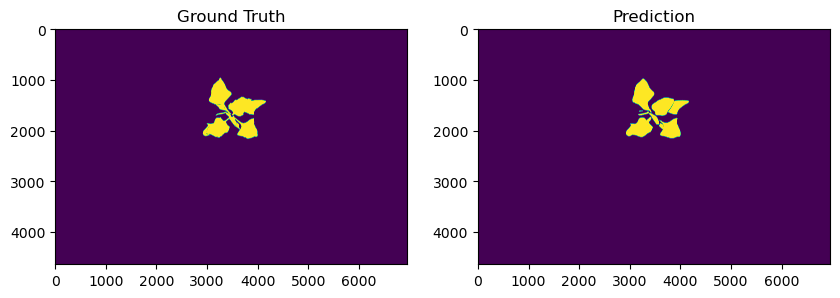

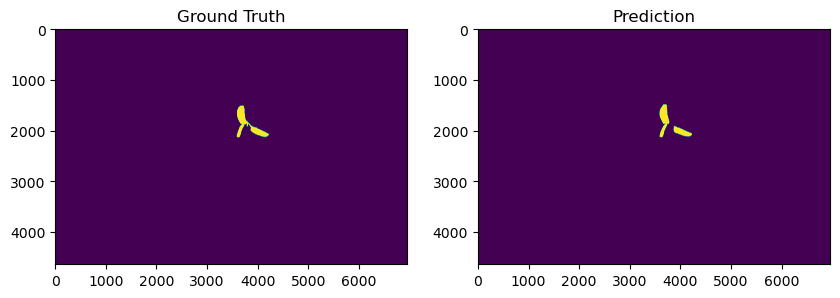

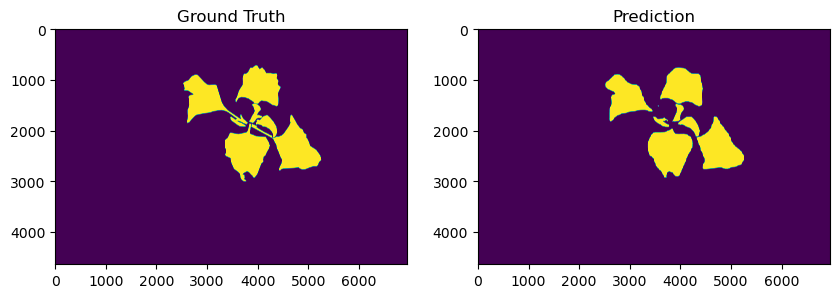

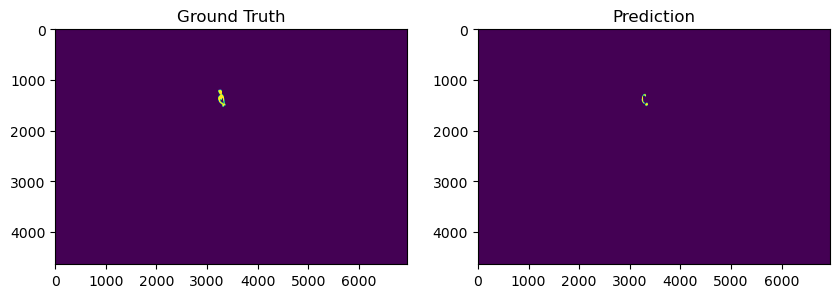

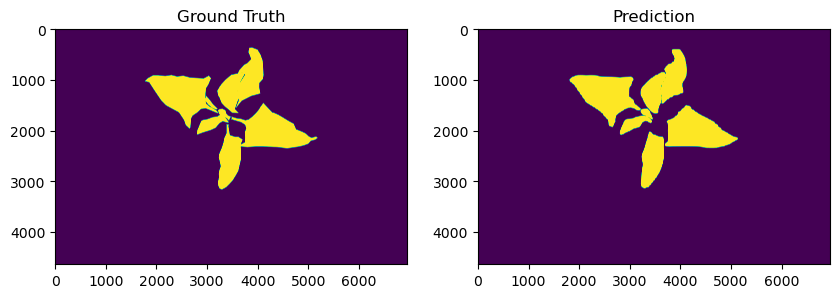

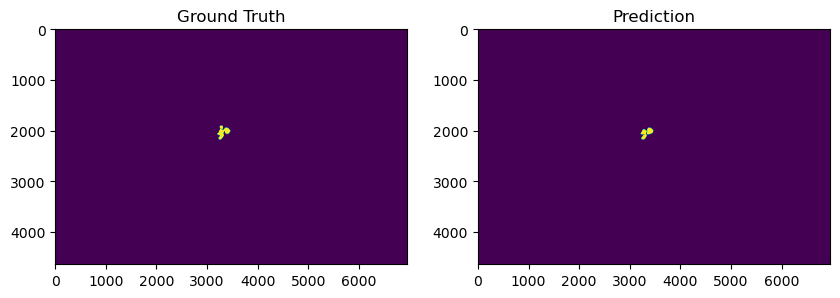

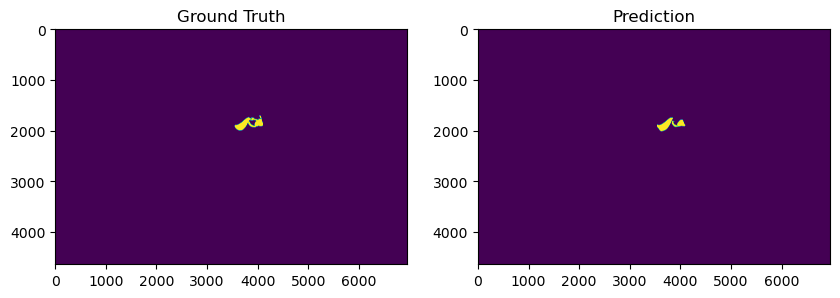

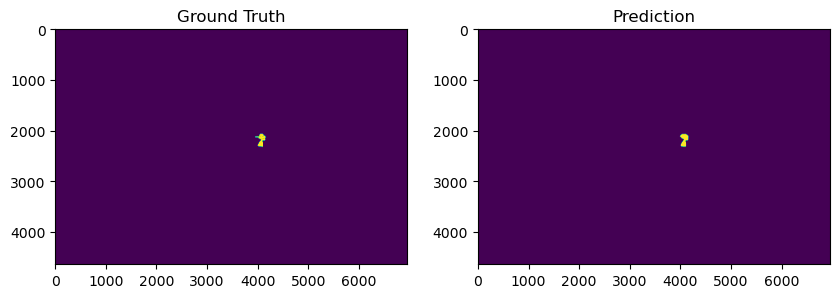

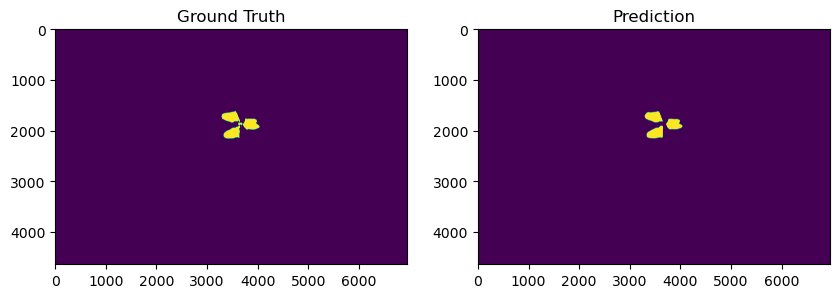

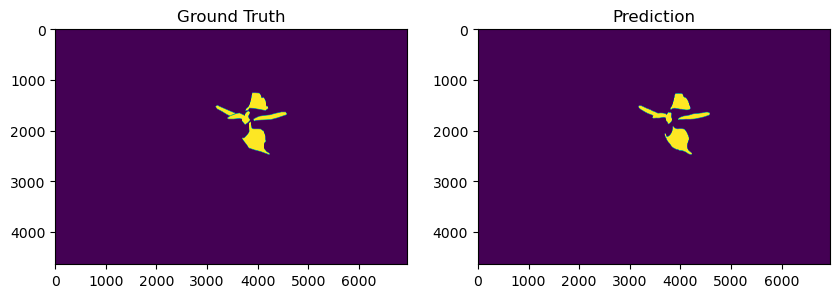

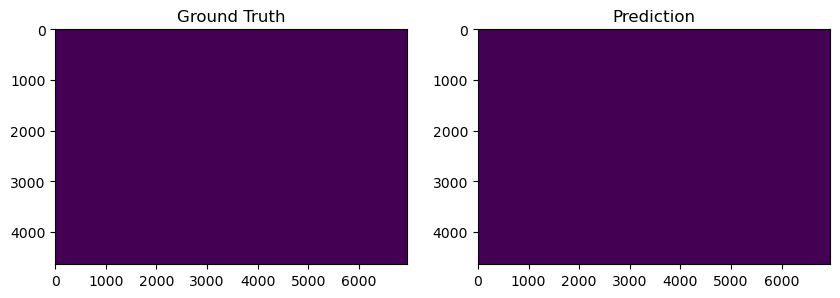

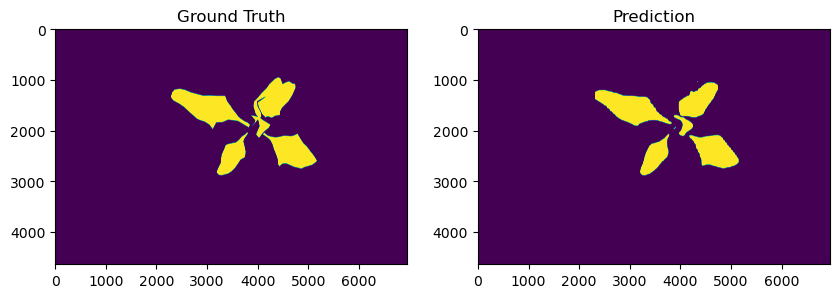

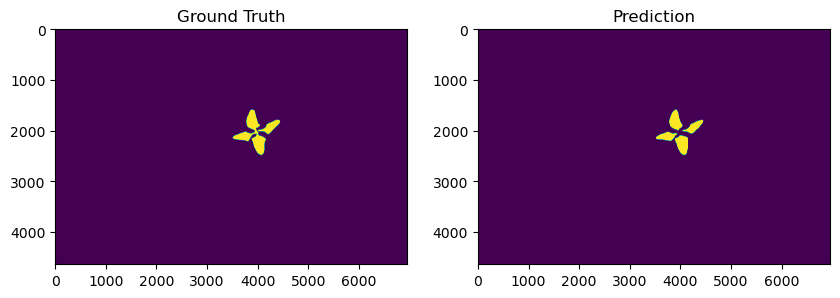

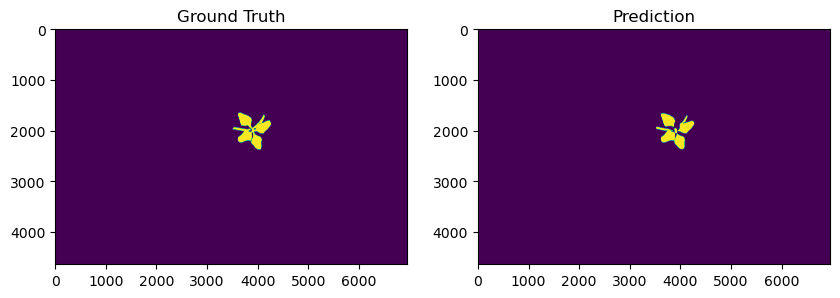

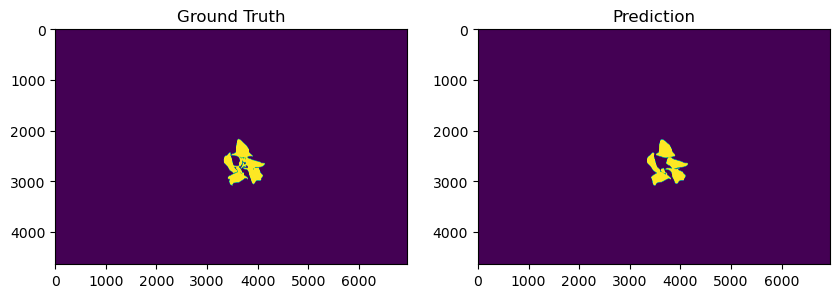

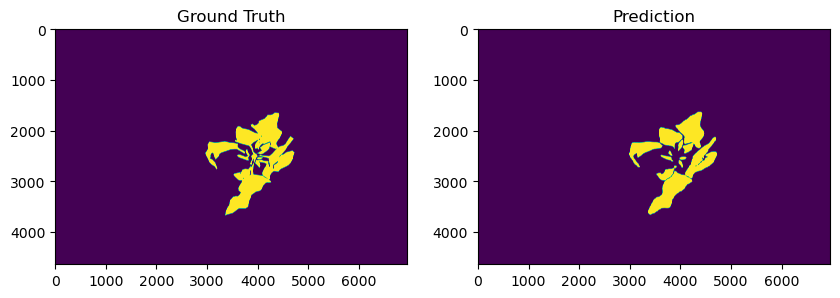

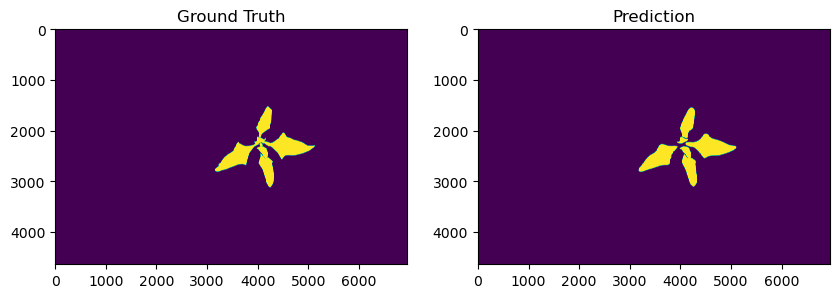

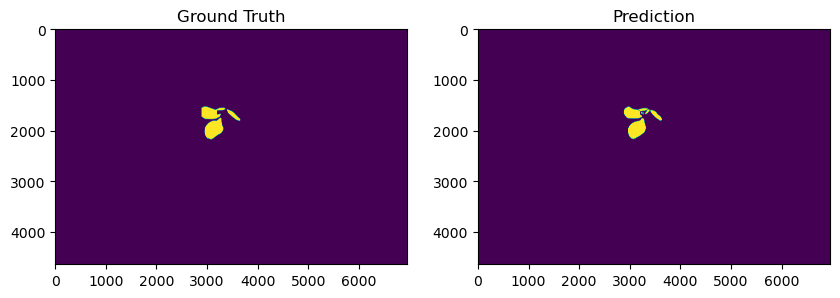

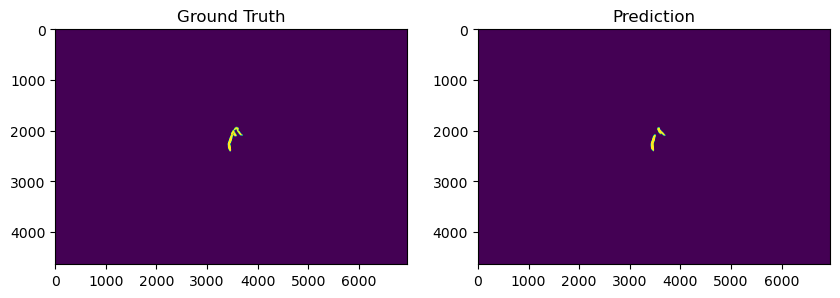

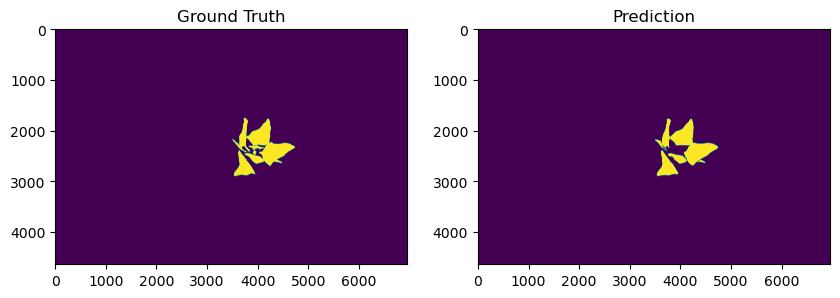

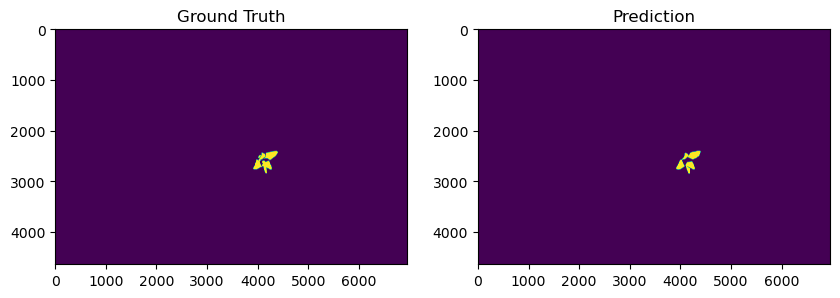

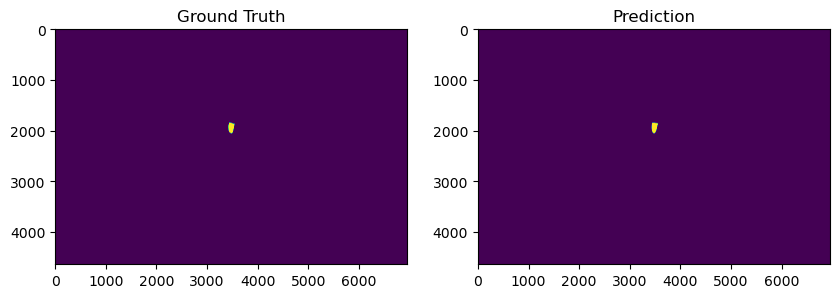

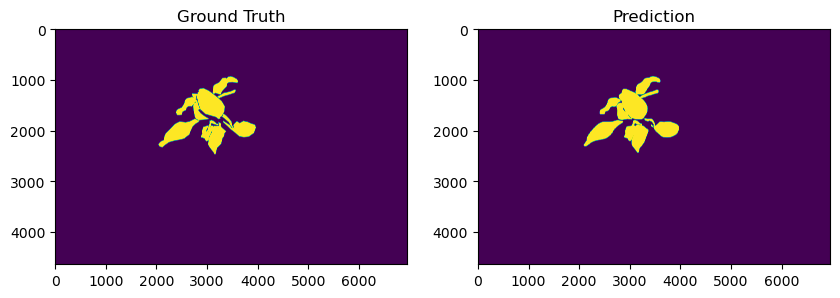

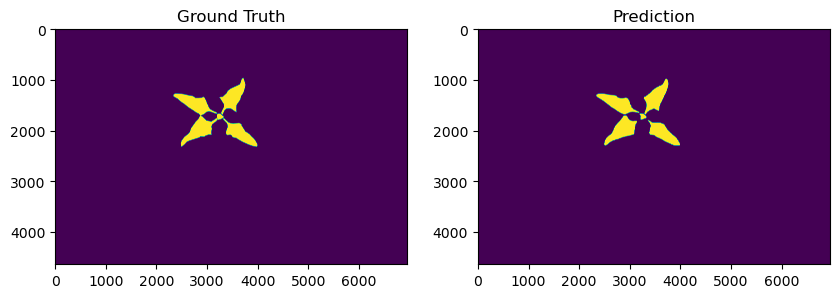

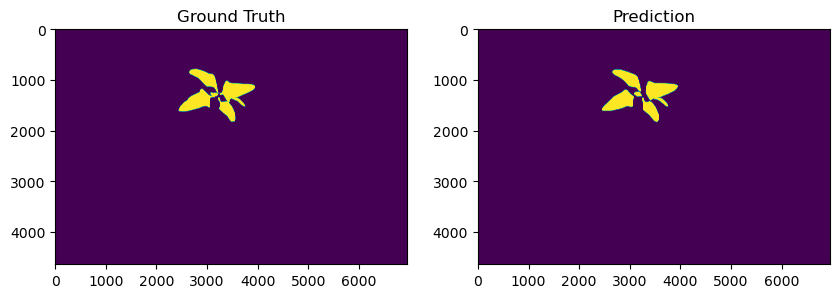

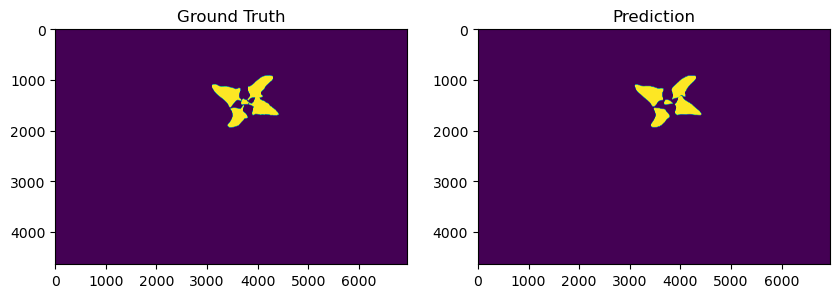

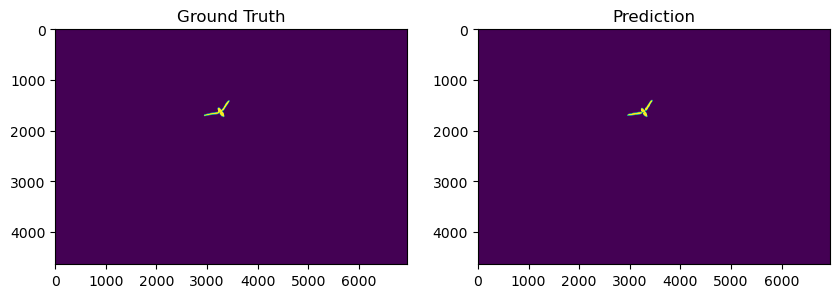

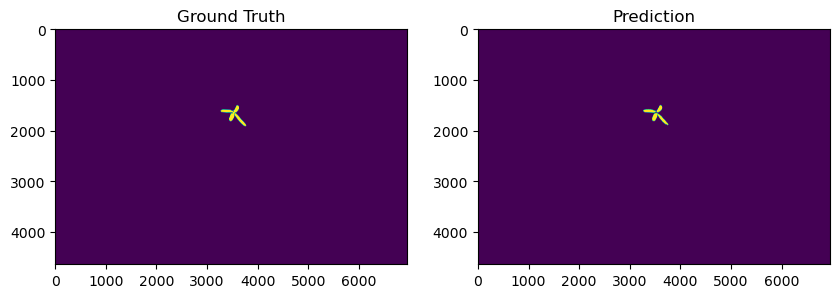

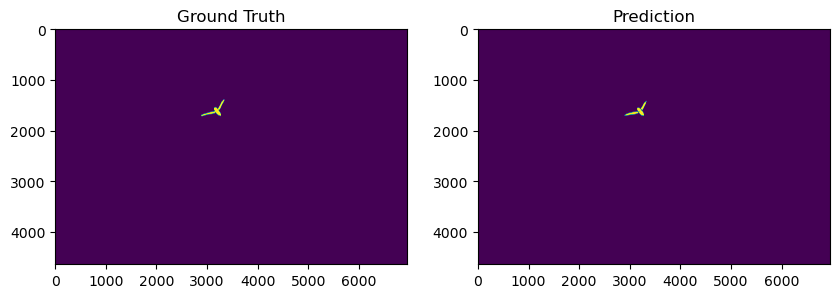

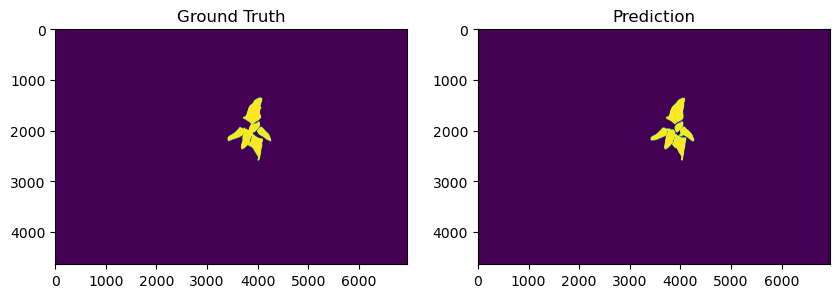

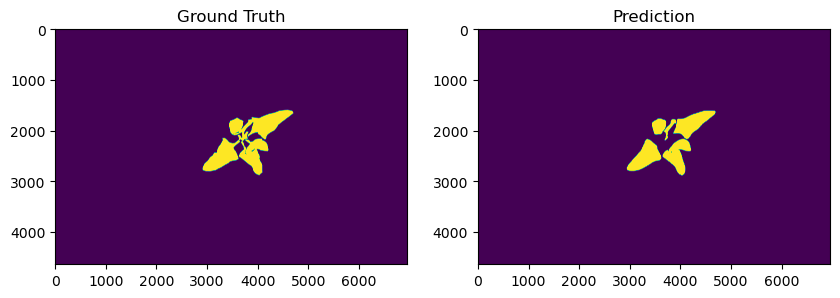

In [44]:
sample_ious = []
sample_dice = []

# sample = dataset.last()
for sample in dataset:
    
    print('\n --------------------------------------------------------------')
    print('\nSample: ', sample.filepath)

    # ------- get bboxes & masks for GROUND TRUTH and PREDICTIONS ------ #

    ground_truth_detections = sample.ground_truth.detections
    prediction_detections = sample.predictions.detections

    height = sample.height
    width  = sample.width

    ground_truth_bboxes = []
    ground_truth_masks = []

    prediction_bboxes = []
    prediction_masks = []
    detectron2_bboxes = []


    # get bboxes and masks from ground truth
    for d in ground_truth_detections:
        if (d.label == 'leaf'):
            ground_truth_bboxes.append(d.bounding_box)
            ground_truth_masks.append(d.mask)

    # get bboxes and masks from predictions
    for d in prediction_detections:
        if (d.label == 'leaf'):
            prediction_bboxes.append(d.bounding_box)
            prediction_masks.append(d.mask)
            detectron2_bboxes.append(d.original_bbox)



    # ---------- assemble PREDICTION mask for entire photo ------------ #
    complete_prediction_mask = np.zeros((height, width))


    for index, bbox in enumerate(prediction_bboxes):
        x1, y1, x2, y2 = convert_to_pixels(bbox, height, width)
        complete_prediction_mask[round(y1):round(y2), round(x1):round(x2)] = np.logical_or(complete_prediction_mask[round(y1):round(y2), round(x1):round(x2)], prediction_masks[index])

    print('Prediction pixel count: ', np.count_nonzero(complete_prediction_mask))



    # --------- assemble GROUND TRUTH mask for entire photo ----------- #
    complete_ground_truth_mask = np.zeros((height, width))

    for index, bbox in enumerate(ground_truth_bboxes):
        x1, y1, x2, y2 = convert_to_pixels(bbox, height, width)
        complete_ground_truth_mask[round(y1):round(y2), round(x1):round(x2)] = np.logical_or(complete_ground_truth_mask[round(y1):round(y2), round(x1):round(x2)], ground_truth_masks[index])

    print('Ground truth pixel count: ', np.count_nonzero(complete_ground_truth_mask))
    
    
     # ------- calculate Intersection Over Union (Jaccard Index) ------- #

    intersect = np.logical_and(complete_ground_truth_mask, complete_prediction_mask)
    union = np.logical_or(complete_ground_truth_mask, complete_prediction_mask)

    intersect_pixels = np.count_nonzero(intersect)
    union_pixels = np.count_nonzero(union)
    
    iou = None
    
    if intersect_pixels != 0 or union_pixels != 0:  
        iou = intersect_pixels / union_pixels

    print('IOU:', iou)
    sample_ious.append(iou)
    
    # ------------ calculate Dice Coefficient (F1 Score) -------------- #
    
    dice = None
    
    if intersect_pixels != 0 or union_pixels != 0:  
        dice = (2 * intersect_pixels) / (np.count_nonzero(complete_ground_truth_mask) + np.count_nonzero(complete_prediction_mask))

    print('Dice:', dice)
    sample_dice.append(dice)

    # --------- visualize GROUND TRUTH and PREDICTION masks ----------- #
    # if 'IMG_6153' in sample.filepath:
    f, axarr = plt.subplots(1, 2)
    plt.rcParams['figure.figsize'] = [10, 10]
    axarr[0].title.set_text('Ground Truth')
    axarr[1].title.set_text('Prediction')

    axarr[0].imshow(complete_ground_truth_mask)
    axarr[1].imshow(complete_prediction_mask)

    display(f)
 

In [45]:
print(sample_ious)

sample_ious = np.array(sample_ious, dtype=np.float)

print(sample_ious)

# sample_ious[sample_ious == None] = np.nan

print('Min IOU: ', np.nanmin(sample_ious))
print('Max IOU: ', np.nanmax(sample_ious))
print('Average IOU: ', np.nanmean(sample_ious))

print('\n')
# sample_dice[sample_dice == None] = np.nan

sample_dice = np.array(sample_dice, dtype=np.float)

print('Min Dice: ', np.nanmin(sample_dice))
print('Max Dice: ', np.nanmax(sample_dice))
print('Average Dice: ', np.nanmean(sample_dice))





[0.8717127934937434, 0.8545299182477737, 0.848442038230785, 0.9016214777505049, 0.9211830669322785, 0.8644334663478761, 0.902893472641431, 0.3415845615177917, 0.9316546047809383, 0.7481135660387601, 0.7473241179001722, 0.8348964165733482, 0.9059653595176728, 0.8611673187314821, None, 0.8863856411331901, 0.9019201785120085, 0.8975542419674464, 0.8542125027357654, 0.8558823862542333, 0.9050025512807429, 0.8489103864357415, 0.6118066208125092, 0.894268718430149, 0.8336034865871593, 0.8940547311620736, 0.8713646304244936, 0.923373952334305, 0.9146914211114582, 0.9240548283918509, 0.8429740203817999, 0.8468219356036003, 0.8144511258955988, 0.9056366688981691, 0.8721939409139029]
[0.87171279 0.85452992 0.84844204 0.90162148 0.92118307 0.86443347
 0.90289347 0.34158456 0.9316546  0.74811357 0.74732412 0.83489642
 0.90596536 0.86116732        nan 0.88638564 0.90192018 0.89755424
 0.8542125  0.85588239 0.90500255 0.84891039 0.61180662 0.89426872
 0.83360349 0.89405473 0.87136463 0.92337395 0.91

/tmp/ipykernel_137845/2493802070.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_ious = np.array(sample_ious, dtype=np.float)
/tmp/ipykernel_137845/2493802070.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_dice = np.array(sample_dice, dtype=np.float)


In [47]:
total_dice = 0.7693692302489409 + 0.9192198343808647 + 0.8494511989802144 + 0.773003970816042 + 0.9131756362004316
avg_dice = total_dice / 5
print(avg_dice)

0.8448439741252987


In [48]:
total_r2 = 0.7996748496587117 + 0.9963375296453822 + 0.9725001037237607 + 0.9946219916894515 + 0.9971855695035271
avg_r2 = total_r2 / 5
print(avg_r2)

0.9520640088441666
